## Descripcion de ploblemas

Descripción del Proyecto:
En la era actual, Twitter ha emergido como un canal vital de comunicación, especialmente durante situaciones de crisis y emergencia. La proliferación de dispositivos móviles ha habilitado a las personas para reportar eventos en tiempo real, lo que ha llevado a un aumento en la atención por parte de agencias de ayuda en desastres y medios de comunicación.

Sin embargo, discernir si un tweet realmente describe una emergencia no siempre es sencillo. Tomemos este ejemplo:


<img src="tweet_screenshot.png" alt="Texto alternativo" width="300"/>


"La situación está ABLAZE con emociones."

Aunque el término "ABLAZE" se utiliza, su sentido es metafórico y no indica un desastre real. Esto es fácilmente comprendido por seres humanos, especialmente con el contexto visual. Sin embargo, para una máquina, esta distinción puede resultar más compleja.

En este desafío, te invitamos a construir un modelo de aprendizaje automático capaz de predecir cuáles tweets hacen referencia a situaciones de emergencia y cuáles no. Tendrás acceso a un conjunto de datos con 10,000 tweets que han sido clasificados manualmente. Si eres nuevo en el campo del Procesamiento del Lenguaje Natural (PLN), hemos creado un tutorial rápido para facilitar tu inicio.

Ten en cuenta que el conjunto de datos utilizado en este concurso contiene texto que podría ser considerado como lenguaje profano, vulgar u ofensivo.

## Importacion de librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os
import datetime
import missingno as msno
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Funciones

In [2]:
#Descomprimir archivo descargado

def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

#Habilitar tensorboard
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Get dataset


El data set original se encuentra en el siguiente link https://www.kaggle.com/competitions/nlp-getting-started/data


In [3]:
# Obtencion de ruta de archivos

from pathlib import Path
rt = Path.cwd()
rt_base = rt.joinpath("nlp-getting-started.zip")
print("Ruta actual:", rt)

rt_train = rt.joinpath("train.csv")
rt_test = rt.joinpath("test.csv")

Ruta actual: C:\Users\garfi\Desktop\Proyectos\NLP


In [4]:
#Unzip data
unzip_data(rt_base)

## Visuazlizacion del texto del dataset

In [5]:
# Cragamos la data
import pandas as pd
df_train = pd.read_csv(rt_train)
df_test = pd.read_csv(rt_test)

In [6]:
# Mostramos los 20 primeros mensajes
df_train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
#Ejemplos de tweets
df_train.text[1]

'Forest fire near La Ronge Sask. Canada'

<AxesSubplot: >

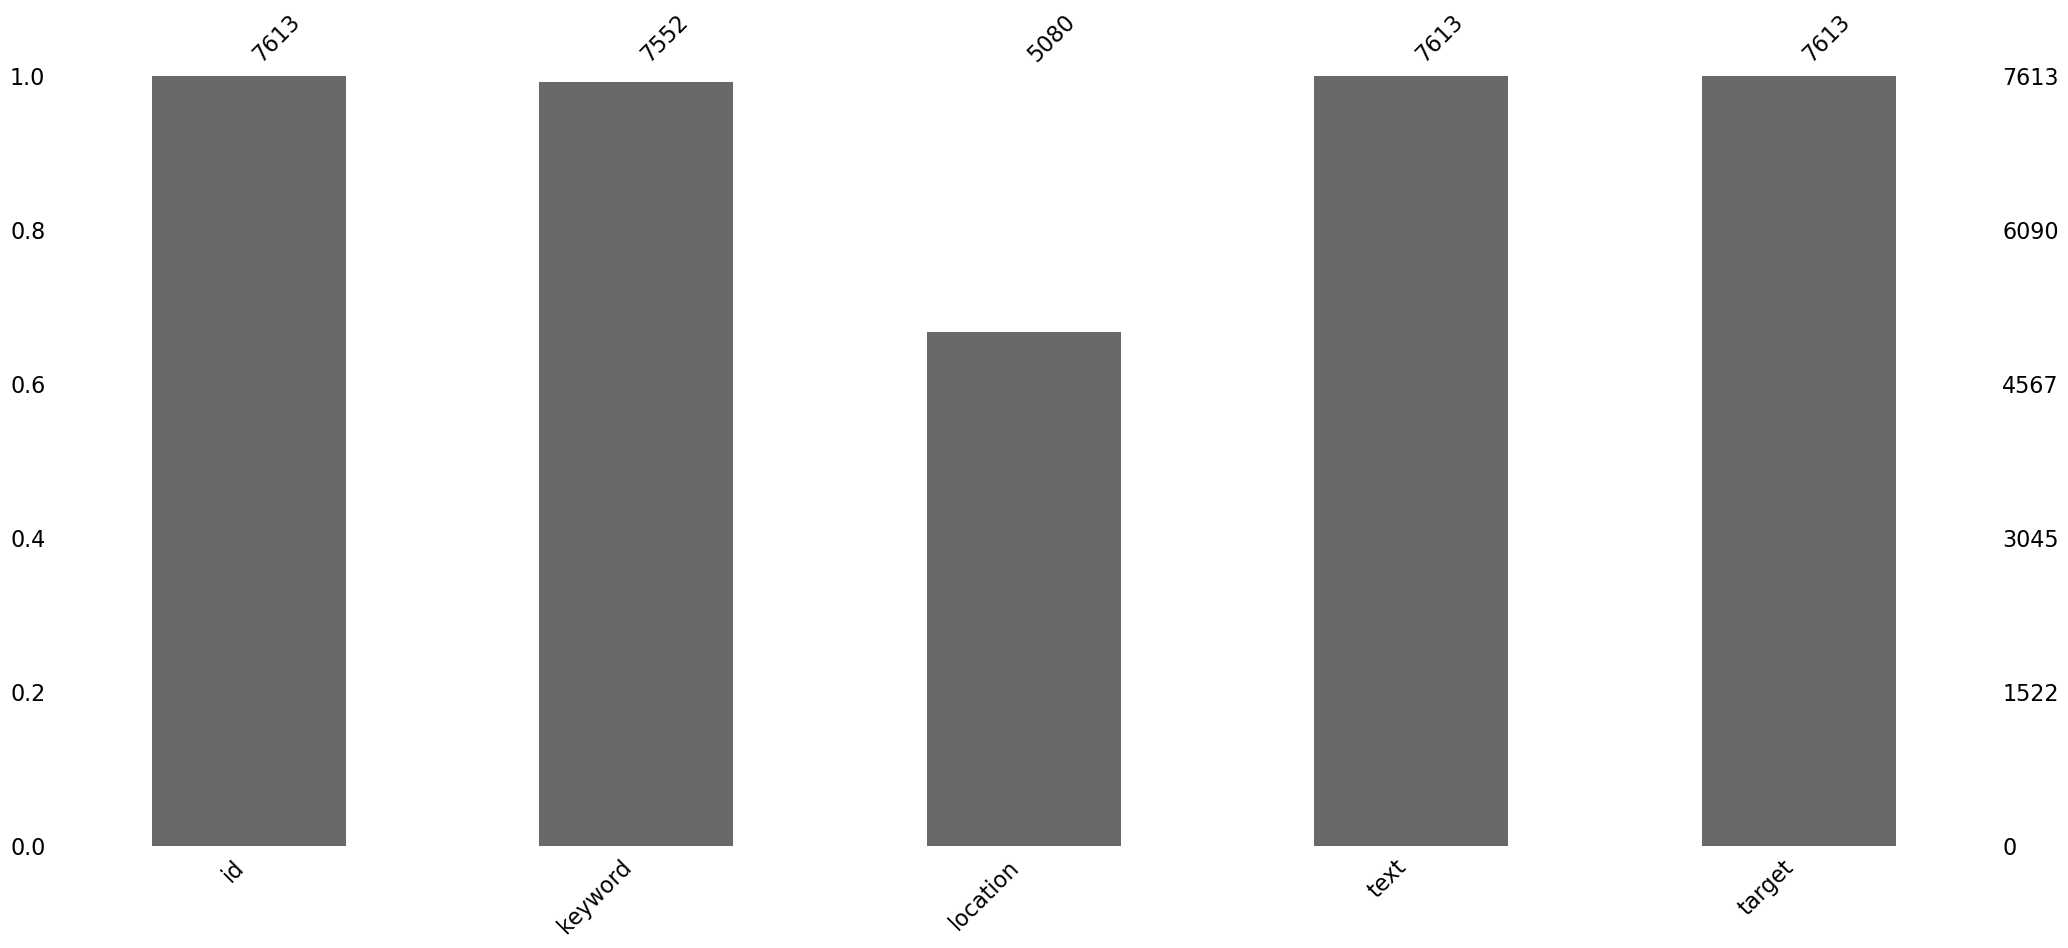

In [8]:
#Cantidad de datos nulos, 
msno.bar(df_train)

In [9]:
#Este resumen destaca la presencia de valores ausentes en las variables "Keyword" y "Location". 
#La variable "Keyword" captura palabras clave y "Location" indica el origen del tweet.

In [10]:
#Mezclamos aleatoriamiento las filas

df_train_sd = df_train.sample(frac=1, random_state=42)
df_train_sd.head(1000)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
7107,10183,violent%20storm,??? ???? ?f glory. ?,@Skarletan åÇ the storm. A violent swell of em...,0
6284,8976,storm,"Charlotte, NC",Severe T-storm Warning for Union County ~3:45p...,1
131,190,aftershock,NaN,Aftershock https://t.co/jV8ppKhJY7,0
4128,5869,hailstorm,"Wyoming, MI (Grand Rapids)",If you're gonna take a break at work.... you g...,0


In [11]:
# La variable target actúa como indicador: toma el valor 1 para mensajes que son desastres y 0 para aquellos que no lo son.

In [12]:
# Mostramos las 5 primeras filas de nuestra data de testeo
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


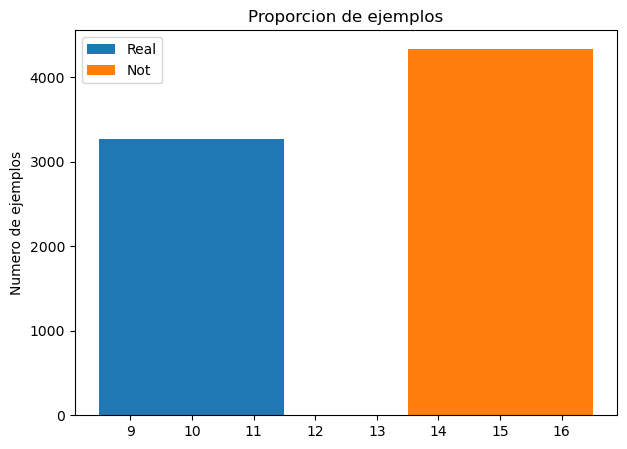

In [13]:
#Cantidad de tweets por desastres
Real_len = df_train[df_train['target'] == 1].shape[0]
Not_len = df_train[df_train['target'] == 0].shape[0]
# bar plot de clases
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real")
plt.bar(15,Not_len,3, label="Not")
plt.legend()
plt.ylabel('Numero de ejemplos')
plt.title('Proporcion de ejemplos')
plt.show()

In [14]:
Real_len , Not_len

(3271, 4342)

In [15]:
#Calculamos la cantidad de letras por tweet
df_train[df_train['target']==1]['text'].str.len()

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 3271, dtype: int64

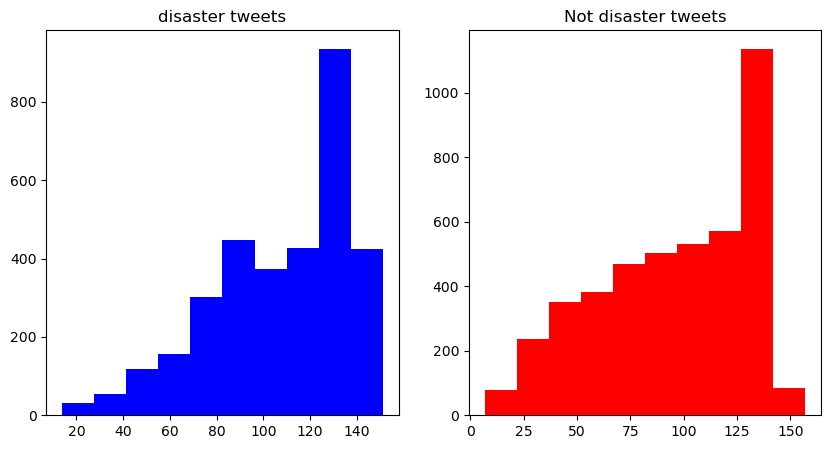

In [16]:
# Cantidad de letras por tweets

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

tweet_len1 = df_train[df_train['target'] == 1]['text'].str.len()
ax1.hist(tweet_len1, color='blue')
ax1.set_title('disaster tweets')
tweet_len2 = df_train[df_train['target'] == 0]['text'].str.len()
ax2.hist(tweet_len2, color='red')
ax2.set_title('Not disaster tweets')

plt.show()

In [17]:
# Mostramos la cantidad maxima de letras por cada target 
max(tweet_len1), max(tweet_len2)

(151, 157)

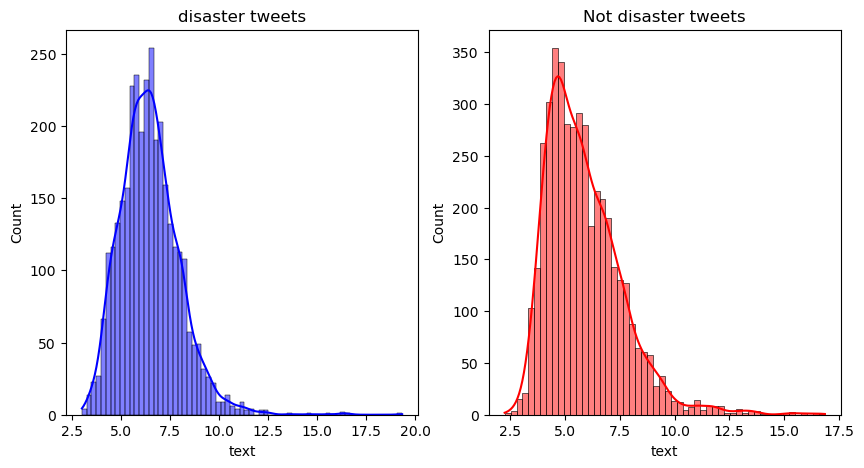

In [18]:
# Promedio de cantidad de palabras por tweet

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word1 = df_train[df_train['target']==1]['text'].str.split().apply(lambda x:[len(i) for i in x])

sns.histplot(word1.map(lambda x: np.mean(x)), kde=True, ax = ax1, color= 'blue')

ax1.set_title('disaster tweets')

word2 = df_train[df_train['target']==0]['text'].str.split().apply(lambda x:[len(i) for i in x])

sns.histplot(word2.map(lambda x: np.mean(x)),kde=True, ax = ax2, color= 'red')
ax2.set_title('Not disaster tweets')

plt.show()

In [19]:
#Cuantos mesajes hay por cada dataset
len(df_train), len(df_test)

(7613, 3263)

In [20]:
#Vamos a visualizar algunos tweets de mensajes de entrenamiento, usamos la libreria random para que nos muestreb tweets aleatorios
import random

ran_index = random.randint(0, len(df_train)-5)

for row in df_train_sd[["text", "target"]][ran_index:ran_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(Desastre real)" if target > 0 else "(No es un desastre)")
    print(f"Texto:\n{text}\n")
    print("---\n")
    

Target: 1 (Desastre real)
Texto:
Nigerian Military Rescue 178 Hostages From Boko Haram - Florida Sentinel Bulletin: Florid... http://t.co/KcTiGYMahl #security #terrorism

---

Target: 1 (Desastre real)
Texto:
Be ember aware! http://t.co/LZmL1xB2nH

---

Target: 1 (Desastre real)
Texto:
The Catastrophic Effects of Hiroshima and Nagasaki Atomic Bombings Still Being Felt Today http://t.co/1kRPz3j1EU

---

Target: 1 (Desastre real)
Texto:
LA Times: Refugio oil spill may have been costlier bigger than projected http://t.co/g37huJx6et

---

Target: 0 (No es un desastre)
Texto:
@mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best.

---



In [21]:
#Vamos a dividir los datos para entrenamiento y validacion

In [22]:
#Usaremos la libreria de sklearn 
from  sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df_train_sd["text"].to_numpy(),
                                                                            df_train_sd["target"].to_numpy(), 
                                                                            test_size= 0.1, 
                                                                            random_state=42)

In [23]:
# Vamos a ver algunos ejemplos de nuestros datos de entrenamiento
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [24]:
# Convertiremos el texto a numero

## Tratamiento de texto

In [25]:
# Usaremos la tokenizacion de tensorflow https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize ="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length=None,
                                    pad_to_max_tokens=True)

In [26]:
# cualcula el promedio de tokens por twets
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

15

In [27]:
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize ="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length= max_length,
                                    pad_to_max_tokens=True)

In [28]:
text_vectorizer.adapt(train_sentences)

In [29]:
#Usamos la funcion random para comparar los tweets y su version vectorizada
random_sentence = random.choice(train_sentences)
print(f"Texto original: \n {random_sentence}\\n\nVersion vectorizada:")

text_vectorizer([random_sentence])

Texto original: 
 Harshness Follows Us a
Better Day
by Sarah C
Racing thoughts with screaming sirens
Pacing back and forth for... http://t.co/ProNtOuo91\n
Version vectorizada:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 2992,   69,    3,  441,  101,   18, 2306, 2170, 4817, 1950,
          14,  311,  568,    1]], dtype=int64)>

In [30]:
#creamos nuesto diccionario

words_in_vocabulary = text_vectorizer.get_vocabulary()

top_5_words = words_in_vocabulary[:5]
bottom_5_words = words_in_vocabulary[-5:]
print(f"Numero de palabras en el diccionario: {len(words_in_vocabulary)}")
print(f"Las 5 palabras mas frecuentes: {top_5_words}")
print(f"Las 5 palabras menos usadas: {bottom_5_words}")

Numero de palabras en el diccionario: 10000
Las 5 palabras mas frecuentes: ['', '[UNK]', 'the', 'a', 'in']
Las 5 palabras menos usadas: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


https://keras.io/api/layers/core_layers/embedding/

In [31]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=10000, output_dim=128, input_length=max_length)
embedding

In [32]:
#Usamos la funcion random para comparar los tweets y su version vectorizada
import random
random_sentence = random.choice(train_sentences)
print(f"Texto original: \n {random_sentence}\\n\nVersion Embedded:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Texto original: 
 Finnish ministers: Fennovoima nuclear reactor will go ahead http://t.co/mqMCOLwBzc\n
Version Embedded:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.02620705,  0.03332034,  0.04223884, ..., -0.00989915,
         -0.04219445,  0.03558644],
        [ 0.04284331, -0.01481979,  0.02412594, ...,  0.02343564,
         -0.00981852, -0.01315828],
        [-0.0467748 , -0.02157801, -0.0093432 , ..., -0.0282401 ,
          0.01499888, -0.03073658],
        ...,
        [ 0.03216621, -0.0375846 , -0.01931648, ...,  0.01709162,
          0.00011279, -0.03006339],
        [ 0.03216621, -0.0375846 , -0.01931648, ...,  0.01709162,
          0.00011279, -0.03006339],
        [ 0.03216621, -0.0375846 , -0.01931648, ...,  0.01709162,
          0.00011279, -0.03006339]]], dtype=float32)>

In [33]:
sample_embed[0][0].shape

TensorShape([128])

## Modelado

Usaremos diferentes modelos y luego compararemos segun sus parametros y el tiempo de respuesta.

### Modelo Base

El modelo Naive Bayes es un algoritmo de aprendizaje supervisado utilizado en el procesamiento del lenguaje natural. A pesar de su suposición simplificada de independencia entre características, es efectivo en la clasificación de texto, como en la detección de spam o análisis de sentimientos. Se basa en el teorema de Bayes, calculando la probabilidad de que un documento pertenezca a una clase dada su evidencia. Aunque su enfoque "ingenuo" puede no ser siempre preciso en el lenguaje natural, sigue siendo útil en diversas aplicaciones de PLN y ofrece una base sólida para comenzar en proyectos de análisis textual.

https://scikit-learn.org/stable/modules/naive_bayes.html

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tfidf", TfidfVectorizer()), ("clf", MultinomialNB())])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [35]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Nuestro modelo base alcanza una precisión de: {baseline_score*100:.2f}%")

Nuestro modelo base alcanza una precisión de: 79.27%


In [36]:
# Realizamos las prediciones
baseline_preds = model_0.predict(val_sentences)

baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [37]:
# Funcion para obtener: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    # Calcular el accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calcular la precision, recall y f1 del modelo
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
    return model_results

In [38]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 2: Dense 

In [39]:
SAVE_DIR = "model_logs"

In [40]:
from tensorflow.keras import layers

# Definición de la entrada de la red: datos de texto
inputs = layers.Input(shape=(1,), dtype=tf.string)

# Aplicación del vectorizador de texto a las entradas
x = text_vectorizer(inputs)

# Aplicación de una capa de embedding para representar palabras en un espacio vectorial
x = embedding(x)

# Aplicación de una capa de Global Average Pooling para obtener características agregadas
x = layers.GlobalAveragePooling1D()(x)

# Capa de salida densa con función de activación sigmoide para la clasificación binaria
outputs = layers.Dense(1, activation="sigmoid")(x)

# Creación del modelo con las capas de entrada y salida definidas
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [41]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [42]:
# Compilación del modelo:
# Se define la función de pérdida 'binary_crossentropy' debido a que se trata de un problema de clasificación binaria.

model_1.compile(loss='binary_crossentropy',  # Utiliza la función de pérdida binary_crossentropy
                optimizer=tf.keras.optimizers.Adam(),  # Selecciona el optimizador Adam para ajustar los pesos
                metrics=["accuracy"])  # Selecciona la métrica de evaluación "accuracy" (exactitud)


In [43]:
# Entrenamiento del modelo:
# Se utiliza el método fit para entrenar el modelo con los datos de entrenamiento.

model_1_history = model_1.fit(train_sentences,  # Datos de texto de entrenamiento
                              train_labels,  # Etiquetas correspondientes a los datos de entrenamiento
                              epochs=5,  # Número de épocas de entrenamiento
                              validation_data=(val_sentences, val_labels),  # Datos de validación para evaluar el modelo durante el entrenamiento
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,  # Lista de devoluciones de llamada para el seguimiento del entrenamiento
                                                                     experiment_name="simple_dense_model")])  # Nombre del modelo para TensorBoard


Saving TensorBoard log files to: model_logs/simple_dense_model/20230815-193730
Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.6125 - accuracy: 0.6942 - val_loss: 0.5370 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4400 - accuracy: 0.8189 - val_loss: 0.4723 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3460 - accuracy: 0.8603 - val_loss: 0.4567 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2838 - accuracy: 0.8930 - val_loss: 0.4657 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2378 - accuracy: 0.9121 - val_loss: 0.4777 - val_accuracy: 0.7835


In [44]:
#Evaluamos los modelos
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4777 - accuracy: 0.7835


[0.47771328687667847, 0.7834645509719849]

In [45]:
# Como en la ultima capa tenemos una funcion 'sigmoid', el resultado es una probabilidad
# Es por eso que si nos da un resultado <= 0.5 se redondeara a 0 y si >0.5 entonces se redondeara a 1
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

24/24 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [46]:
# Obtenemos las metricas del model_1.
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7875988615317319,
 'recall': 0.7834645669291339,
 'f1': 0.7806382038884261}

### Modelo 3: LSTM
Los modelos LSTM son herramientas poderosas para el análisis de texto y el procesamiento del lenguaje natural debido a su capacidad para modelar dependencias a largo plazo en secuencias. Su aplicación abarca desde la detección de sentimientos hasta la generación de texto, y son especialmente útiles cuando se trabaja con datos de texto estructurados en forma de secuencias.

https://keras.io/api/layers/recurrent_layers/lstm/

In [47]:
# Set random seed and create embedding layer (new embedding layer for each model)
# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Importación de capas necesarias de Keras
from tensorflow.keras import layers

# Creación de una capa de Embedding
model_2_embedding = layers.Embedding(input_dim=10000,  # Tamaño del vocabulario
                                     output_dim=128,  # Dimensión de los vectores de embedding
                                     embeddings_initializer="uniform",  # Inicializador para los vectores de embedding
                                     input_length=15,  # Longitud máxima de las secuencias de entrada
                                     name="embedding_2")  # Nombre de la capa de embedding

# Creación del modelo LSTM
inputs = layers.Input(shape=(1,), dtype="string")  # Definición de la entrada del modelo
x = text_vectorizer(inputs)  # Vectorización de los datos de texto
x = model_2_embedding(x)  # Aplicación de la capa de embedding
print(x.shape)  # Imprimir la forma de los datos después de la capa de embedding
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x)  # Aplicación de la capa LSTM para capturar patrones en las secuencias
print(x.shape)  # Imprimir la forma de los datos después de la capa LSTM
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)  # Capa de salida con activación sigmoide para clasificación binaria
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")  # Creación del modelo LSTM final

(None, 15, 128)
(None, 64)


In [48]:
# Compilamos el modelo
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [50]:
# Entrenamos el modelo
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230815-193746
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.5149 - accuracy: 0.7378 - val_loss: 0.4569 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3195 - accuracy: 0.8714 - val_loss: 0.5050 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2187 - accuracy: 0.9181 - val_loss: 0.5869 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1549 - accuracy: 0.9457 - val_loss: 0.6134 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1085 - accuracy: 0.9603 - val_loss: 0.8917 - val_accuracy: 0.7585


In [51]:
# Realizamos la prediccion con nuestro modelo
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] 
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

24/24 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [52]:
# Obtenemos las metricas del modelo
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.8530183727034,
 'precision': 0.7588734100545125,
 'recall': 0.7585301837270341,
 'f1': 0.7569752644555794}

### Modelo 3: GRU

Los modelos GRU son una herramienta valiosa en el procesamiento del lenguaje natural, especialmente cuando se trabaja con secuencias de datos, como en el análisis de texto. Proporcionan un equilibrio entre eficiencia computacional y la capacidad de capturar dependencias a largo plazo en el texto, lo que los convierte en una opción sólida para una variedad de tareas de PLN, desde la generación de texto hasta la clasificación de sentimientos.

https://keras.io/api/layers/recurrent_layers/gru/

In [53]:
# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Importación de capas necesarias de Keras
from tensorflow.keras import layers

# Creación de una nueva capa de Embedding
model_3_embedding = layers.Embedding(input_dim=10000,  # Tamaño del vocabulario
                                     output_dim=128,  # Dimensión de los vectores de embedding
                                     embeddings_initializer="uniform",  # Inicializador para los vectores de embedding
                                     input_length=15,  # Longitud máxima de las secuencias de entrada
                                     name="embedding_3")  # Nombre de la capa de embedding

# Construcción de un modelo RNN utilizando la celda GRU
inputs = layers.Input(shape=(1,), dtype="string")  # Definición de la entrada del modelo
x = text_vectorizer(inputs)  # Vectorización de los datos de texto
x = model_3_embedding(x)  # Aplicación de la nueva capa de embedding
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)  # Aplicación de la capa GRU para capturar patrones en las secuencias
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)  # Capa de salida con activación sigmoide para clasificación binaria
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")  # Creación del modelo RNN con celda GRU


In [54]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Resumen del modelo
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [56]:
# Entrenamos el modelo
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230815-193809
Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.5241 - accuracy: 0.7306 - val_loss: 0.4520 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3187 - accuracy: 0.8683 - val_loss: 0.4905 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2166 - accuracy: 0.9190 - val_loss: 0.5546 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1535 - accuracy: 0.9483 - val_loss: 0.6172 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1175 - accuracy: 0.9597 - val_loss: 0.5990 - val_accuracy: 0.7717


In [57]:
# Realizar predicciones
model_3_pred_probs = mon the validation datadel_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.3281195 ],
        [0.89954036],
        [0.99666953],
        [0.14477286],
        [0.01412501],
        [0.99117833],
        [0.77986634],
        [0.9966966 ],
        [0.99637353],
        [0.33059546]], dtype=float32))

In [58]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [59]:
# Calculo de metricas del model_3.
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.7715668446582516,
 'recall': 0.7716535433070866,
 'f1': 0.7706989403422689}

### Modelo 4: Bidireccional

Los modelos bidireccionales son una elección valiosa en PLN cuando se busca aprovechar tanto el contexto histórico como el futuro en las secuencias de texto. Su capacidad para capturar relaciones complejas y dependencias a lo largo del tiempo los convierte en herramientas efectivas para una variedad de tareas en el procesamiento del lenguaje natural.

https://keras.io/api/layers/recurrent_layers/bidirectional/

In [60]:
# Configuración de la semilla aleatoria para reproducibilidad
tf.random.set_seed(42)

# Importación de capas necesarias de Keras
from tensorflow.keras import layers

# Creación de una nueva capa de Embedding para el Modelo_4
model_4_embedding = layers.Embedding(input_dim=10000,  # Tamaño del vocabulario
                                     output_dim=128,   # Dimensión de los vectores de embedding
                                     embeddings_initializer="uniform",  # Inicializador para los vectores de embedding
                                     input_length=15,  # Longitud máxima de las secuencias de entrada
                                     name="embedding_4")  # Nombre de la capa de embedding

# Construcción de un modelo Bidireccional RNN en TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")  # Definición de la entrada del modelo
x = text_vectorizer(inputs)  # Vectorización de los datos de texto
x = model_4_embedding(x)  # Aplicación de la capa de embedding del Modelo_4
# x = ayers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x)  # Aplicación de una capa Bidireccional LSTM
outputs = layers.Dense(1, activation="sigmoid")(x)  # Capa de salida con activación sigmoide para clasificación binaria
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")  # Creación del modelo Bidireccional RNN (Modelo_4)


In [61]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [62]:
# Entrenamiento del modelo
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230815-193833
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.5091 - accuracy: 0.7451 - val_loss: 0.4577 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3136 - accuracy: 0.8732 - val_loss: 0.5110 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2126 - accuracy: 0.9186 - val_loss: 0.5615 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1475 - accuracy: 0.9494 - val_loss: 0.6327 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1048 - accuracy: 0.9648 - val_loss: 0.6806 - val_accuracy: 0.7703


In [64]:
# Realizamos la predicciones 
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

24/24 [==============================] - 1s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.59055118110236,
 'precision': 0.7556331774317685,
 'recall': 0.7559055118110236,
 'f1': 0.7557222691548917}

### Model 5: Tensorflow_hub

 TensorFlow Hub es una herramienta esencial para la comunidad de aprendizaje profundo, ya que agiliza el desarrollo de modelos, fomenta la reutilización de componentes y facilita la adopción de la transferencia de aprendizaje. Su capacidad para proporcionar módulos preentrenados y embeddings de alta calidad beneficia enormemente a los proyectos de procesamiento del lenguaje natural y otras áreas del aprendizaje automático.
 
 https://www.tensorflow.org/hub?hl=es-419

In [100]:
# Ejemplo de uso de embedding preentrenado con Universal Sentence Encoder - https://tfhub.dev/google/universal-sentence-encoder/4
sample_sentence = "¡Hay una inundación en mi calle!"

# Importación de TensorFlow Hub
import tensorflow_hub as hub

# Cargar el Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Usar el Universal Sentence Encoder para obtener representaciones vectoriales de las frases
embed_samples = embed([sample_sentence,
                      "Cuando aplicas el Universal Sentence Encoder a una frase, la convierte en números."])

# Imprimir los primeros 50 elementos del vector de embedding de la primera frase
print(embed_samples[0][:50])

tf.Tensor(
[-0.01287159  0.05315952  0.05392484  0.03079978  0.05855708  0.0524225
  0.04398075  0.03060796 -0.03271952  0.00657884  0.04034415  0.0359103
 -0.00879112  0.03417332 -0.03774025 -0.05475707  0.02143976  0.08621974
  0.04503858 -0.05397467  0.01770658 -0.09263439 -0.02060814  0.05660139
 -0.08536645 -0.05841196  0.06736203  0.09203748 -0.0611566   0.06203809
  0.03962864  0.03620769  0.00113532 -0.01646397 -0.01250913 -0.01595898
 -0.03727921  0.09086922  0.0928834  -0.06918707 -0.02164153  0.00747521
 -0.08177635  0.03594043 -0.03297003 -0.0051822  -0.04390968 -0.03557628
  0.07693119 -0.03524608], shape=(50,), dtype=float32)


In [68]:
# Podemos utilizar esta capa de codificación en lugar de nuestro text_vectorizer y la capa de embedding
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # Forma de las entradas que llegan a nuestro modelo 
                                        dtype=tf.string, # Tipo de datos de las entradas que llegan a la capa USE
                                        trainable=False, # Mantener los pesos preentrenados (crearemos un extractor de características)
                                        name="USE")

In [69]:
# Crear un modelo utilizando la API Sequential
model_5 = tf.keras.Sequential([
  sentence_encoder_layer, # Toma frases y las codifica en un embedding
  layers.Dense(64, activation="relu"), # Capa densa con función de activación ReLU
  layers.Dense(1, activation="sigmoid") # Capa densa con activación sigmoide para clasificación binaria
], name="model_6_USE") # Nombrar el modelo como "model_6_USE"

# Compilar el modelo
model_5.compile(loss="binary_crossentropy", # Función de pérdida para clasificación binaria
                optimizer=tf.keras.optimizers.Adam(), # Optimizador Adam
                metrics=["accuracy"]) # Métrica de precisión

# Imprimir un resumen del modelo
model_5.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [71]:
# Entrenar un clasificador sobre embeddings preentrenados
model_5_history = model_5.fit(train_sentences,  # Datos de entrenamiento (frases)
                              train_labels,  # Etiquetas de entrenamiento (clasificación binaria)
                              epochs=5,  # Número de épocas de entrenamiento
                              validation_data=(val_sentences, val_labels),  # Datos de validación
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230815-194100
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.5044 - accuracy: 0.7822 - val_loss: 0.4456 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4142 - accuracy: 0.8145 - val_loss: 0.4342 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3988 - accuracy: 0.8225 - val_loss: 0.4298 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3908 - accuracy: 0.8275 - val_loss: 0.4258 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3838 - accuracy: 0.8313 - val_loss: 0.4273 - val_accuracy: 0.8163


In [74]:
# Realizar las prediciones con TF Hub model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

24/24 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculamos model 6 performance metrics
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 81.62729658792651,
 'precision': 0.8190827553840537,
 'recall': 0.8162729658792651,
 'f1': 0.8146067773916925}

## Comparacion de modelos

In [76]:
# Combinamos en un dataframe todos los modelos entrenados
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "tf_hub_sentence_encoder": model_5_results})
                            
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.346457,0.787599,0.783465,0.780638
lstm,75.853018,0.758873,0.758530,0.756975
gru,77.165354,0.771567,0.771654,0.770699
bidirectional,75.590551,0.755633,0.755906,0.755722
tf_hub_sentence_encoder,81.627297,0.819083,0.816273,0.814607


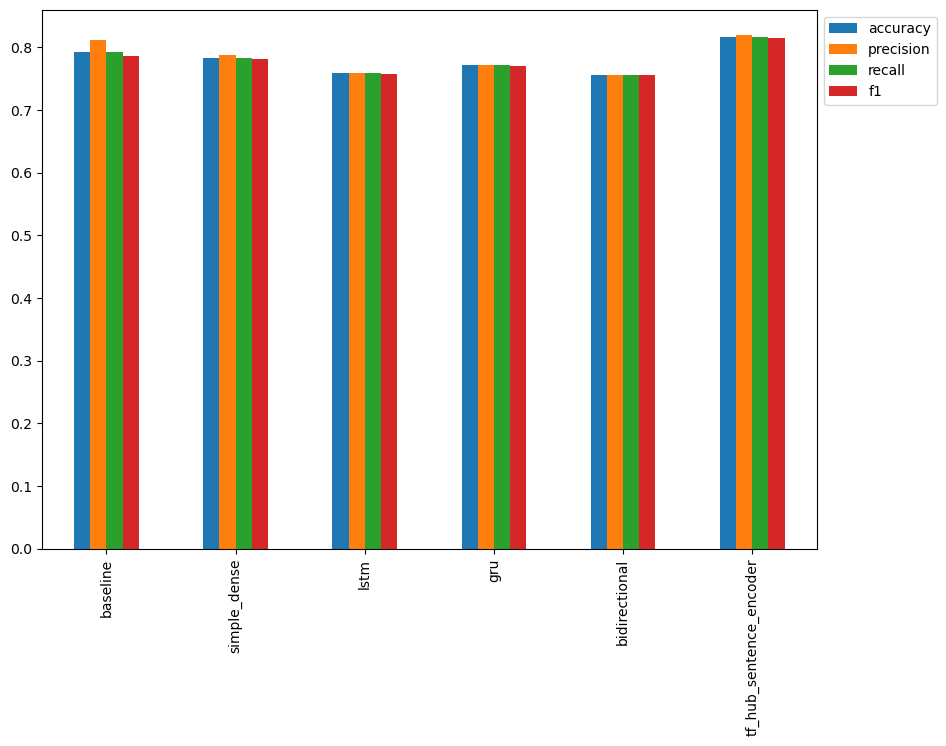

In [77]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
#Comparacion de todos los modelos
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [78]:
#Guardamos el modelo con mejor performance

model_5.save("model_5.h5")

C:\Users\garfi\anaconda3\envs\bmrl\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_5_preds,
                       "pred_prob": tf.squeeze(model_5_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.165855
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.735076
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990613
3,@camilacabello97 Internally and externally scr...,1,0.0,0.225904
4,Radiation emergency #preparedness starts with ...,1,1.0,0.716033


In [81]:
# Buscamos las predicciones incorrectas
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
# Mostramos las 5 primeros falsos positivos
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.915929
759,FedEx will no longer transport bioterror patho...,0,1.0,0.866831
628,@noah_anyname That's where the concentration c...,0,1.0,0.865212
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.832721
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.826885


In [82]:
#Mostramos el target con el valor predicho y ademas el tweet de los falsos positivos
for row in most_wrong[:10].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 0, Pred: 1, Prob: 0.915928840637207
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8668312430381775
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.865212082862854
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8327214121818542
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8268852233886719
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.810752272605896
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob:

In [83]:
#Mostramos el target con el valor predicho y ademas el tweet de los falsos negativos
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, prob = row
    print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
    print(f"Text:\n{text}\n")
    print("----\n")

Target: 1, Pred: 0, Prob: 0.06633877754211426
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06441458314657211
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.0578339621424675
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.057508423924446106
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.052175164222717285
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.045405056327581406
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04528023302555084
Text:
@SoonerMagic_ I mean I'm a fan but I d

In [84]:
# Mostramos prediciones aleatorias
test_sentences = df_test["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_5.predict([test_sample])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n{test_sample}\n")
    print("----\n")

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.2782013416290283
Text:
@cieIstea IDK BUT IT BLEW UP

----

1/1 [==============================] - 0s 32ms/step
Pred: 1, Prob: 0.9660051465034485
Text:
Police officer wounded suspect dead after exchanging shots: A Richmond police officer was wounded and a suspe... http://t.co/FzQPiQeCHB

----

1/1 [==============================] - 0s 31ms/step
Pred: 0, Prob: 0.1806291788816452
Text:
New Nanotech Device Will Be Able To Target And Destroy Blood Clots http://t.co/MnmyJXQ9go #science

----

1/1 [==============================] - 0s 30ms/step
Pred: 1, Prob: 0.7987779378890991
Text:
@chistate33 @thehill What hate crimes? It's the looney libs that are always burning down buildings and vandalzing private property

----

1/1 [==============================] - 0s 31ms/step
Pred: 0, Prob: 0.11918588727712631
Text:
Peddle to the floorboard.. End up in a four door. Burning up a backroad song... Park it and we pile outÛ_ Baby watc

In [85]:
def predict_on_sentence(model, sentence):
    
    pred_prob = model.predict([sentence])
    pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
    print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
    print(f"Text:\n{sentence}")

Mostramos el performance del modelo en un tweet

https://twitter.com/SpokespersonCHN/status/1691424443820843008

In [86]:
Example_tweet = "Situated in Shaanxi Province on the Loess Plateau, the city of Yan'an was one of the regions most susceptible to serious soil erosion in the country. Now Yan'an is a national forest and garden city with lush and vibrant greens. #GreenChina"

In [87]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_5, # use the USE model
                    sentence=Example_tweet)

1/1 [==============================] - 0s 32ms/step
Pred: 0.0 (not real disaster) Prob: 0.4742772579193115
Text:
Situated in Shaanxi Province on the Loess Plateau, the city of Yan'an was one of the regions most susceptible to serious soil erosion in the country. Now Yan'an is a national forest and garden city with lush and vibrant greens. #GreenChina


In [88]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [89]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_5, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 29ms/step
Pred: 1.0 (real disaster) Prob: 0.9715663194656372
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [90]:
import time
def pred_timer(model, samples):

    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time # calculate how long predictions took to make
    time_per_pred = total_time/len(val_sentences) # find prediction time per sample
    return total_time, time_per_pred

In [93]:
model_5_total_pred_time, model_5_time_per_pred = pred_timer(model_5, val_sentences)
model_5_total_pred_time, model_5_time_per_pred

24/24 [==============================] - 0s 6ms/step


(0.20018100000004324, 0.0002627047244095056)

In [92]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time0, baseline_time_per_pred0 = pred_timer(model_0, val_sentences)
# Calculate Naive Bayes prediction times
baseline_total_pred_time1, baseline_time_per_pred1 = pred_timer(model_1, val_sentences)
baseline_total_pred_time2, baseline_time_per_pred2 = pred_timer(model_2, val_sentences)
baseline_total_pred_time3, baseline_time_per_pred3 = pred_timer(model_3, val_sentences)
baseline_total_pred_time4, baseline_time_per_pred4 = pred_timer(model_3, val_sentences)

24/24 [==============================] - 0s 3ms/step


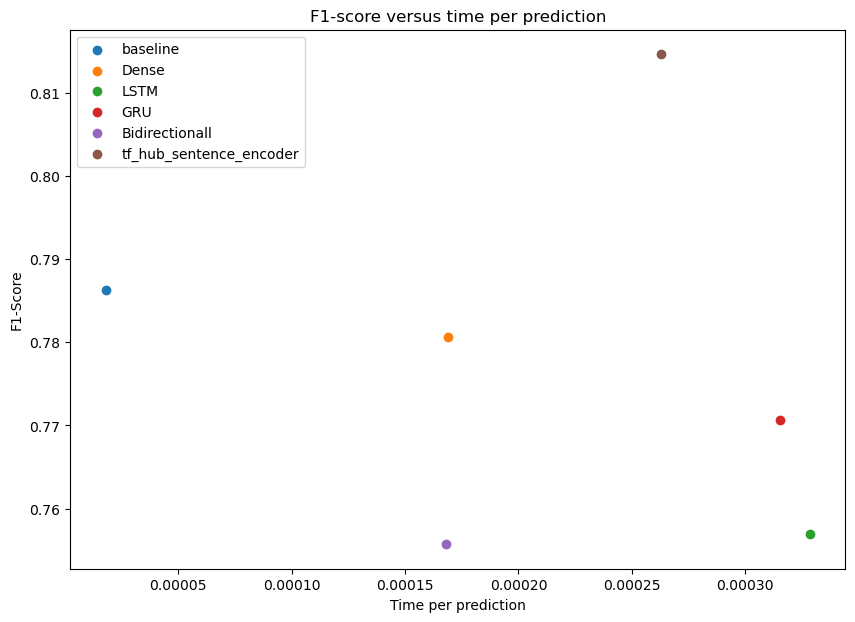

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred0, baseline_results["f1"], label="baseline")
plt.scatter(baseline_time_per_pred1, model_1_results["f1"], label="Dense")
plt.scatter(baseline_time_per_pred2, model_2_results["f1"], label="LSTM")
plt.scatter(baseline_time_per_pred3, model_3_results["f1"], label="GRU")
plt.scatter(baseline_time_per_pred4, model_4_results["f1"], label="Bidirectionall")
plt.scatter(model_5_time_per_pred, model_5_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

### Conclusion

La comparación revela que el Modelo_5 (utilizando TensorFlow Hub) logra la mayor accuracy, precision, recall y F1-score, demostrando su eficacia en la tarea de clasificación de tweets. 

En términos de tiempo de predicción, el Modelo_base es el más rápido, seguido por el Modelo_4 (Bidireccional). Los modelos LSTM y GRU (Modelos_2 y _3) requieren más tiempo debido a su naturaleza secuencial. El Modelo_5 (TensorFlow Hub) también demuestra ser eficiente en términos de tiempo de predicción

Modelo_5 (TensorFlow Hub) destaca por su rendimiento general, mientras que el Modelo_base y el Modelo_4 (Bidireccional) son eficientes en cuanto al tiempo de predicción. La elección del modelo dependerá de un equilibrio entre precisión y eficiencia en función de los requisitos específicos del proyecto.